# Imports / Libraries

In [4]:
import importlib.util
import subprocess

def install(package):
    if importlib.util.find_spec(package) is None:
        subprocess.run(["pip", "install", package, "-q"])
        print(f'{package} installed.')
    else:
        print(f'{package} already installed.')

install("numpy")
install("tensorflow")
install("pillow")
install("matplotlib")
install("tqdm")

numpy already installed.
tensorflow already installed.
pillow installed.
matplotlib already installed.
tqdm already installed.


In [5]:
import requests
import numpy as np
from zipfile import ZipFile, BadZipFile
import os
import tensorflow as tf 
from PIL import Image, UnidentifiedImageError
from typing import List
from pathlib import Path
import matplotlib.pyplot as plt
import random
import tqdm

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## COCO Dataset Retrival (ONLY RUN IF NOT DOWNLOADED)

In [ ]:
urls = ['http://images.cocodataset.org/zips/train2017.zip', 'http://images.cocodataset.org/zips/val2017.zip']
dests = ['coco_train2017.zip', 'coco_val2017.zip']

for url, dest in zip(urls, dests):
    try:
        with requests.get(url, stream=True) as response:
            response.raise_for_status()
            with open(dest, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
        print(f'File {dest} downloaded successfully')
    except requests.exceptions.RequestException as e:
        print(f'Error downloading file: {e}')

In [ ]:
# unzip file
def extract_file(path: str):
    try:
        with ZipFile(path+'.zip') as z:
            z.extractall(path)

            zipToRemove = f'{dest}'
            #if os.path.isfile(zipToRemove):
                #os.remove(zipToRemove)
            #else:
                #print(f'Error: {zipToRemove} file not found')
    except BadZipFile as e:
        print(f'Error: {e}')

extract_file('./coco_train2017')
extract_file('./coco_val2017')

## Data EDA

In [52]:
# extract images from file
train_files = list(Path('./train2017').iterdir())
val_files = list(Path('./val2017').iterdir())
print(f"Total train images: {len(train_files)}")
print(f"Total val images: {len(val_files)}")


# preprocess into tensors + resize to 128x128 and put rgb vals between 0 and 1
def preprocess_img(img_file) -> tf.Tensor:
    try:
        img = Image.open(img_file).convert("RGB")
        img_arr = np.array(img).astype(np.float32) / 255.0
        img_tensor = tf.convert_to_tensor(img_arr)
        img_resized = tf.image.resize(img_tensor, (128, 128))
        return tf.clip_by_value(img_resized, 0.0, 1.0) # between 0 and 1 vals
    except (IOError, UnidentifiedImageError) as e:
        print(f'Error extracting image {img}, {e}')
        return None

def create_dataset(imgs, batch_size=16):
    dataset = tf.data.Dataset.from_generator(
        lambda: (preprocess_img(img) for img in imgs),
        output_signature=tf.TensorSpec(shape=(128,128,3), dtype=tf.float32)
    )

    dataset = dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

processed_train, processed_val = create_dataset(train_files), create_dataset(val_files)

Total train images: 118287
Total val images: 5000


In [53]:
data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
])
processed_train = processed_train.map(lambda x: data_aug(x), num_parallel_calls=tf.data.AUTOTUNE)


Shape:  (32, 128, 128, 3)


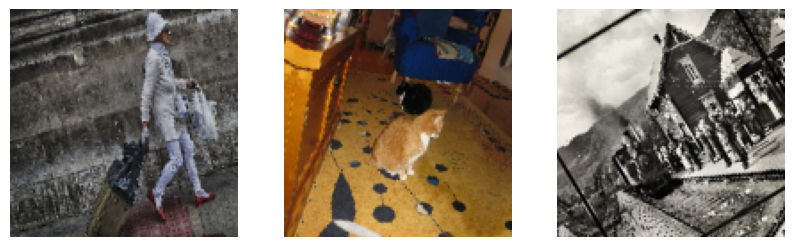

In [54]:
# showcase 3 images from the dataset!
batch = next(iter(processed_train))
print('Shape: ', batch.shape)
three_ex_train = batch[:3].numpy()

plt.figure(figsize=(10,5))

for i, img in enumerate(three_ex_train):
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.axis("off")
plt.show()

## Model Building

To re-generate images, we are going to use a **diffusion denoising CNN model**. This model will incrementally add noise over a series of steps.

In [55]:
# q(x_t|x_(t-1)) = N(x_t; sqrt(1-b_t*x_(t-1), b_t*I)))
# reparameterized: x_t = sqrt(a_t*x_0) + sqrt(1-a_t*epsilon)
# forward pass

class NoiseScheduler():
  def __init__(self, steps, b_start=1e-4, b_end=0.02):
    '''
      b_start: noise variance at early timesteps
      b_end: noise variance at later timesteps
      steps: how many timesteps
    '''
    self.T = steps

    beta = tf.linspace(b_start, b_end, steps)
    alpha = 1 - beta
    self.alpha_bar = tf.math.cumprod(alpha)


  def add_noise(self, x0, t):
    # compute x_t based on timestep t and return image w/noise
    t = tf.clip_by_value(t, 0, self.T - 1)
    t = tf.cast(t, tf.int32)
    at = tf.gather(self.alpha_bar, t)
    at = tf.clip_by_value(at, 1e-6, 1.0)

    noise = tf.random.normal(shape=tf.shape(x0))

    xt = tf.math.sqrt(at) * x0 + tf.math.sqrt(1-at) * noise
    return xt, noise

  def remove_noise(self, xt, pred, t):
    t = tf.clip_by_value(t, 0, self.T - 1)
    t = tf.cast(t, tf.int32)
    at = tf.cast(tf.gather(self.alpha_bar, t), tf.float32)

    xt_prev = (xt - ((1 - at) / tf.sqrt(1-at))* pred) / tf.sqrt(at) # reverse step
    return xt_prev # x_(t-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.018473996..1.031744].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3424908..1.348079].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5712388..1.5859764].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90407586..1.7754499].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0596911..2.2491112].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2894892..2.3633265].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.77473

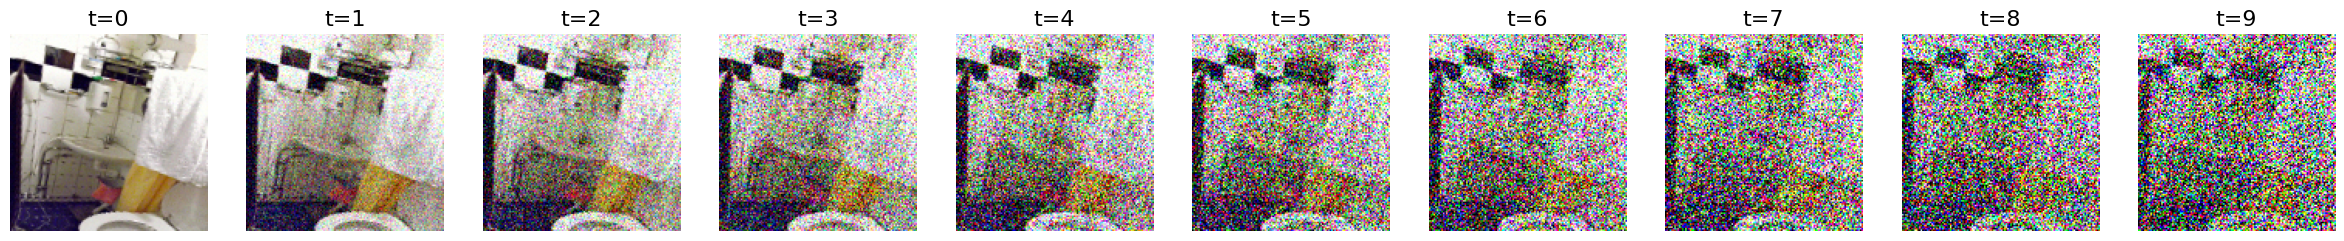

In [188]:
# example of image getting noisy
noiser = NoiseScheduler(steps=10, b_end=0.1)
img = next(iter(processed_train))[5].numpy()

fig, axes = plt.subplots(1, 10, figsize=(30, 10), sharex=True, sharey=True)

for t in range(10):
  noise, _ = noiser.add_noise(img, t)
  axes[t].imshow(noise, cmap="gray")
  axes[t].set_title(f"t={t}", fontsize=16)
  axes[t].axis('off')

plt.show()

In [189]:
class RegenerateModel(tf.keras.Model):
  def __init__(self, steps):
    super(RegenerateModel, self).__init__()
    self.convs = [
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'), # Low level features
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),  # Larger noise structure
        tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),  
    ]
    self.final = tf.keras.layers.Conv2D(3, (3,3), activation='tanh', padding='same') # 3 RGB Channels, outputs noise estimates
    self.optimizer = tf.keras.optimizers.Adam()
      
    self.noiser = NoiseScheduler(steps)
    self.steps = steps
    self.embedding_size = 64

  def call(self, inputs, t, training=True):
    '''
      Forward pass of the model.
      inputs: images for the model to use
      t: current timestep
    '''
    # sinusoidal encoding (condition model for timestep t)
    # PE(t, 2i) = sin(t / 10000^(2i/d))
    # PE(t, 2i+1) = cos(t / 10000^(2i/d))
    batch_size = tf.shape(inputs)[0]
    t = tf.cast(tf.reshape(t, ()), tf.float32)
      
    i = tf.range(self.embedding_size // 2, dtype=tf.float32)
    div = tf.math.pow(10000.0, (2*i) / self.embedding_size)
    pe_sin = tf.math.sin(t / div)
    pe_cos = tf.math.cos(t / div)
    # convert to tensor, reshape then broadcast
    t_emb = tf.concat([pe_sin, pe_cos], axis=-1)
    t_emb = tf.reshape(t_emb, (1,1,1, self.embedding_size))
    t_emb = tf.broadcast_to(t_emb, [batch_size, 128, 128, self.embedding_size])
    # add noise to the model based on timestep
    if training:
        x_t, true_noise = self.noiser.add_noise(inputs, t)
    else:
        x_t = inputs
        true_noise = None
    x_t = tf.concat([x_t, t_emb], axis=-1)
    # pass through CNN layers
    x = x_t
    for conv in self.convs:
        x = conv(x)
    return self.final(x), true_noise # predicted + ground truth noise

  def train_step(self, data):
    '''
      Backpropagation of the model
      data: images for the model to use
    '''
    # sample random timestep t
    batch_size = tf.shape(data)[0]
    t = tf.random.uniform(shape=(),minval=0, maxval=self.noiser.T, dtype=tf.int32)

    # backpropagation
    with tf.GradientTape() as tape:
      predicted_noise, true_noise = self(data, t, training=True)
      loss = tf.keras.losses.MeanSquaredError()(true_noise, predicted_noise)

    # compute + update gradients
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    return {"loss": loss}

  def regenerate_image(self, img, steps=1000):
    x_t, _ = self.noiser.add_noise(img, tf.constant(steps))
    for t in range(steps, 0, -1):
      predicted_noise, _ = self(x_t, tf.constant(t), training=False)
      x_t = self.noiser.remove_noise(x_t, predicted_noise, t)
    return tf.clip_by_value(x_t, 0.0, 1.0)

## Model Training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-652.521..685.553].


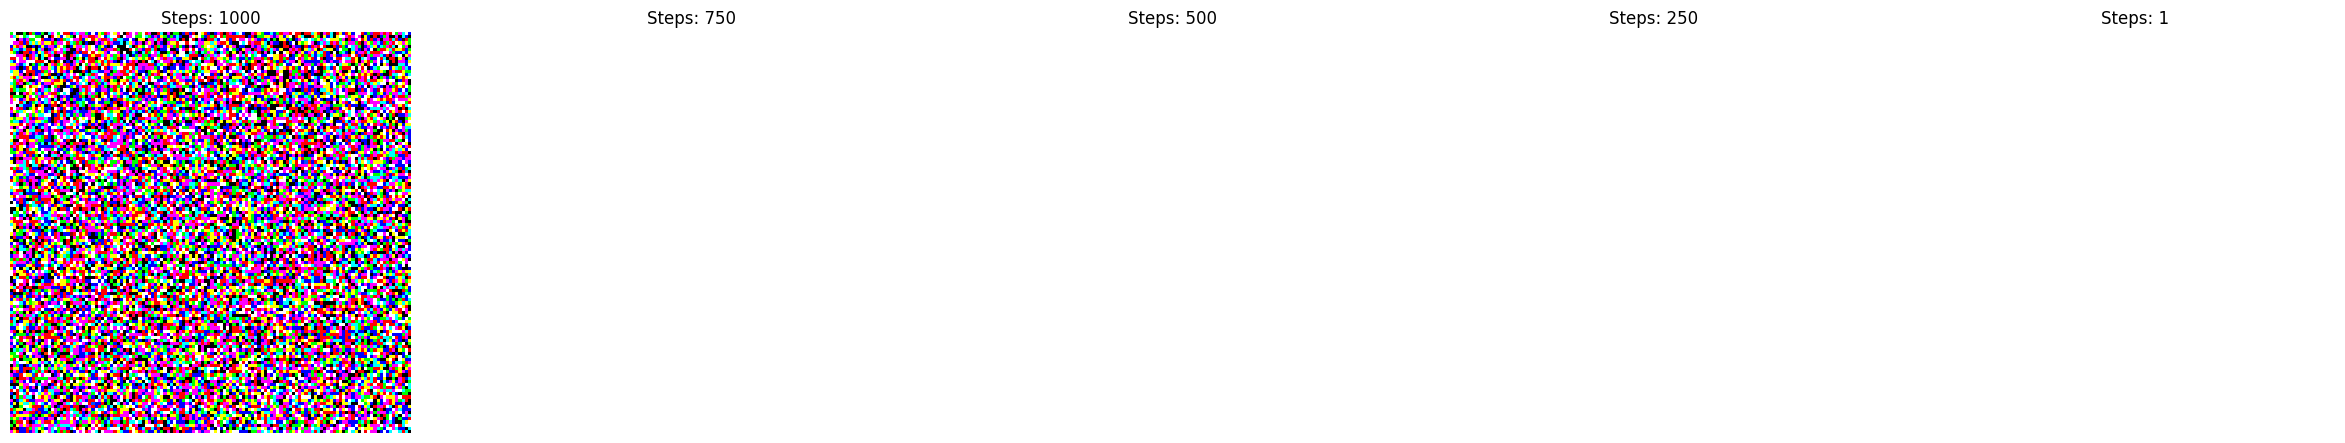

In [191]:
# forward prop + backprop test
# we should see the noise function progressively destroying our structure
steps = [1000, 750, 500, 250, 1]
img = next(iter(processed_train))[5]
img = tf.expand_dims(img, axis=0)

fig, axes = plt.subplots(1, len(steps), figsize=(30, 10), sharex=True, sharey=True)

model = RegenerateModel(steps=max(steps))

noisy_img, _ = model.noiser.add_noise(img, tf.constant(max(steps)))

for step, ax in zip(steps, axes):
    x_t = noisy_img

    for t in range(max(steps), step - 1, -1):
        pred_noise, _ = model(x_t, tf.constant(t), training=False)
        x_t = model.noiser.remove_noise(x_t, pred_noise, t)

    dis = (x_t + 1) / 2

    ax.imshow(x_t[0])
    ax.set_title(f'Steps: {step}')
    ax.axis('off')
plt.show()

Min: 0.0 Max: 1.0


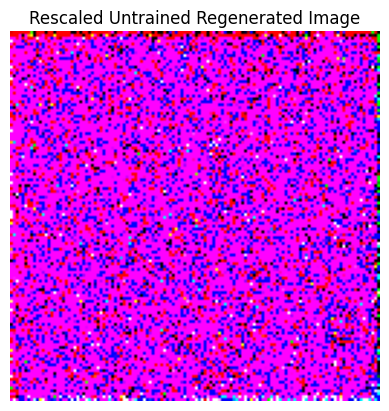

In [196]:
regen_img = model.regenerate_image(noisy_img, steps=100)

print("Min:", tf.reduce_min(regen_img).numpy(), "Max:", tf.reduce_max(regen_img).numpy())

regen_img = (regen_img - tf.reduce_min(regen_img)) / (tf.reduce_max(regen_img) - tf.reduce_min(regen_img) + 1e-8)

plt.imshow(regen_img[0].numpy())
plt.title("Rescaled Untrained Regenerated Image")
plt.axis("off")
plt.show()

In [197]:
def ssim_loss(y_t, y_p):
    return tf.reduce_mean(tf.image.ssim(y_t, y_p, 2.0))

# Training

In [198]:
epochs = 20
model = RegenerateModel(steps=2000)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=ssim_loss)

model.fit(processed_train, epochs=epochs, batch_size=32)

model.save_weights('photo_regen.weights.h5')

Epoch 1/20
3697/3697 ━━━━━━━━━━━━━━━━━━━━ 3393s 917ms/step - loss: 0.2420
Epoch 2/20


2025-03-09 17:48:48.299639: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13288058662964251099


3697/3697 ━━━━━━━━━━━━━━━━━━━━ 3442s 931ms/step - loss: 0.1871 
Epoch 3/20


2025-03-09 18:46:09.932896: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13288058662964251099


3697/3697 ━━━━━━━━━━━━━━━━━━━━ 3452s 934ms/step - loss: 0.1821
Epoch 4/20
3697/3697 ━━━━━━━━━━━━━━━━━━━━ 3411s 923ms/step - loss: 0.1784 
Epoch 5/20


2025-03-09 20:40:33.289677: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13288058662964251099


3697/3697 ━━━━━━━━━━━━━━━━━━━━ 3381s 915ms/step - loss: 0.1775
Epoch 6/20
3697/3697 ━━━━━━━━━━━━━━━━━━━━ 3407s 922ms/step - loss: 0.1748 
Epoch 7/20
3697/3697 ━━━━━━━━━━━━━━━━━━━━ 3362s 910ms/step - loss: 0.1725
Epoch 8/20


2025-03-09 23:29:43.441047: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13288058662964251099


3697/3697 ━━━━━━━━━━━━━━━━━━━━ 3391s 917ms/step - loss: 0.1717
Epoch 9/20
3697/3697 ━━━━━━━━━━━━━━━━━━━━ 3366s 910ms/step - loss: 0.1711
Epoch 10/20


2025-03-10 01:22:20.496664: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13288058662964251099


3697/3697 ━━━━━━━━━━━━━━━━━━━━ 3393s 918ms/step - loss: 0.1694 
Epoch 11/20
3697/3697 ━━━━━━━━━━━━━━━━━━━━ 3397s 919ms/step - loss: 0.1686
Epoch 12/20
3697/3697 ━━━━━━━━━━━━━━━━━━━━ 3416s 924ms/step - loss: 0.1672
Epoch 13/20


2025-03-10 04:12:26.438931: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13288058662964251099


3697/3697 ━━━━━━━━━━━━━━━━━━━━ 3390s 917ms/step - loss: 0.1652 
Epoch 14/20


2025-03-10 05:08:56.699081: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13288058662964251099


3697/3697 ━━━━━━━━━━━━━━━━━━━━ 3391s 917ms/step - loss: 0.1639 
Epoch 15/20


2025-03-10 06:05:27.521889: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13288058662964251099


3697/3697 ━━━━━━━━━━━━━━━━━━━━ 3354s 907ms/step - loss: 0.1652
Epoch 16/20
3697/3697 ━━━━━━━━━━━━━━━━━━━━ 3383s 915ms/step - loss: 0.1637
Epoch 17/20


2025-03-10 07:57:44.567985: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13288058662964251099


3697/3697 ━━━━━━━━━━━━━━━━━━━━ 3382s 915ms/step - loss: 0.1651
Epoch 18/20


2025-03-10 08:54:06.153620: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13288058662964251099


3697/3697 ━━━━━━━━━━━━━━━━━━━━ 3386s 916ms/step - loss: 0.1643
Epoch 19/20


2025-03-10 09:50:31.962351: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13288058662964251099


3697/3697 ━━━━━━━━━━━━━━━━━━━━ 3375s 913ms/step - loss: 0.1631
Epoch 20/20
3697/3697 ━━━━━━━━━━━━━━━━━━━━ 3374s 913ms/step - loss: 0.1633


2025-03-10 11:43:00.588266: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13288058662964251099


# Testing

In [199]:
epochs = 10
model = RegenerateModel(steps=1000)

_, _ = model(noisy_img, tf.constant(1))
model.compile(optimizer=tf.keras.optimizers.Adam(),  loss=ssim_loss, metrics=[ssim_loss, 'accuracy'])
model.load_weights('photo_regen.weights.h5')

In [200]:
for layer in model.layers:
    weights = layer.get_weights()
    if weights:
        print(layer.name, "Weights shape:", [w.shape for w in weights])


conv2d_315 Weights shape: [(3, 3, 67, 64), (64,)]
conv2d_316 Weights shape: [(3, 3, 64, 64), (64,)]
conv2d_317 Weights shape: [(3, 3, 64, 128), (128,)]
conv2d_318 Weights shape: [(3, 3, 128, 128), (128,)]
conv2d_319 Weights shape: [(3, 3, 128, 3), (3,)]


Min: 0.0 Max: 0.9486185


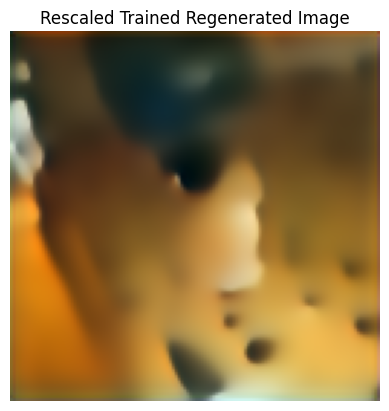

In [212]:
img = tf.expand_dims(next(iter(processed_train))[1], axis=0)
regen_img = model.regenerate_image(img, steps=25)

print("Min:", tf.reduce_min(regen_img).numpy(), "Max:", tf.reduce_max(regen_img).numpy())

regen_img = (regen_img - tf.reduce_min(regen_img)) / (tf.reduce_max(regen_img) - tf.reduce_min(regen_img) + 1e-8)

plt.imshow(regen_img[0].numpy())
plt.title("Rescaled Trained Regenerated Image")
plt.axis("off")
plt.show()

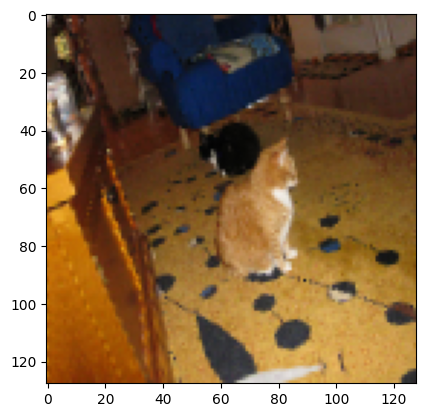

In [202]:
plt.imshow(next(iter(processed_train))[1])